# Question 1:

Write a notebook (R, Python, etc.) where you briefly explain the idea of sample splitting to evaluate the performance of prediction rules to a fellow student, and show how to use it on the wage data. 

# Introduction:
Across a population, some outcome $Y$ can be explained by a function of explantory variables $X$ such that $Y = f(X) + \epsilon$. Research often attemps to uncover this latent relationship with available data. This, in part, leads to the problem of prediction, which boils down to two questions:

1. What combination of variables $X$ best explains $Y$, such that our estimated model $\hat{f}(X)$ closely resembles $Y$?
2. How can I assess each model I build?


This notebook attemps provide additional insights to the second question by introducing and motivating the use sample splitting as a method to assess a model's predictive power.



# Building Your Model:
Imagine you're a researcher studying the effects of wages for different people. Your goal is to be able to predict person $i$'s wage based off their characteristics $X$. This goal relates to question one of the prediction problem, finding the best $\hat{f}(X)$ $\approx Y$. To do this you collect wage data, assess available covariates, and build a number of models of varying complexity.
***

# Assessing Your Model:
After fitting your models & estimating some $\hat{f}(X) = \hat{\beta_0} + \hat{\beta_1}X_1 + .... \hat{\beta_p}X_p$ you can use a number of metrics to test the model's accucracy. Below are two key measures and their variants:

***
 #### **Meaned Squared Error ($\bold{MSE}$)**: $\frac{1}{n}\Sigma_{i=1}^{n}(Y_i - \hat{f}(X_i))^2$

This measures the average squared distance of individual $i$'s actual wage $Y_i$ and the predicted $\hat{f}(X_i)=\hat{Y_i}$ our model predicts. A lower MSE indicates a better predective model.

 #### **$\bold{R^2}$**: $1 - \frac{MSE}{\frac{1}{n}\Sigma_{i=1}^{n}Y^2_i}$. 
 
 R squared measures the total variation in our outcome explained by our model. By inspection you'll notice that $R^2 \in \{0,1\}$. As the distance between $Y$ and $\hat{Y}$ narrows, $MSE$ grows closers to $0$, meaning $\frac{MSE}{\frac{1}{n}\Sigma_{i=1}^{n}Y^2_i}$ moves closer to $0$. Inversly, if our model is poor at predicting $Y$ then $MSE$ grows larger and $\frac{MSE}{\frac{1}{n}\Sigma_{i=1}^{n}Y^2_i}$ will move closer to 1, leading $R^2$ to equal 0.

#### **Adjusted $\bold{MSE}$ & $\bold{R^2}$**:
 
One issue with both $MSE$ and $R^2$ is mechanical and can be excaperated by working with data involving a large number of variables $p$, a small set of observations $n$, or both. Namely, that adding more variables, regardless of predictive power, will neccesarrily increase $MSE$ and in-turn increase $R^2$. Therefore one solution to curb this artifical inflation of model accucracy is introducing "adjusted" measures of both where we multiple $MSE$ or $R^2$ by a penalizer: $\frac{n}{n-p}$, meaning:

$MSE_{adj}$ : ($\frac{n}{n-p})(\frac{1}{n}\Sigma_{i=1}^{n}(Y_i - \hat{f}(X_i))^2$) \
\
$R_{adj}^2$: ($\frac{n}{n-p}) (1 - \frac{MSE}{\frac{1}{n}\Sigma_{i=1}^{n}Y^2_i})$

# Sample Splitting:
After building your models, assessing each, and picking the one with the lowest $MSE$ or highest $R^2$ we are still unsure how this model will fare across the whole population. Ideally in the example above you would have access to the whole population, however collecting such data is costly, timely, and often out of the scope of the research project. A more realistic alternative is testing our model against other randomally sampled datasets, however even this can be too costly to do. This leaves us at an impasse:

***How can we assess our in-sample model's accucracy against observations outside our sample?***

One simple and effective solution comes in the form of *sample splitting*. In short, sample splitting breaks our data into two sets, one set that we use to train a model $\hat{f}(X)$, and another other set we use to test $\hat{f}(X)$ using our assessment metrics.

***


Generally sample splitting (or data splitting) requires only a few key steps:
1. Across our full dataset, split observations $N = \{1, 2, 3, ..., n\}$, into a training set $N_{training}$ & testing set $N_{testing}$. The proportion of observations to be put into $N_{training}$ or $N_{testing}$ is contingent on the complexity of the model, number of observations, and domain context.
2. With $N_{training}$ estimate parameters $\hat{\beta_0}, \hat{\beta_1}, ... \hat{\beta_p}$ from all models $\hat{f}$ you wish to test.
3. With $N_{testing}$, predict their $Y$ as $\hat{Y}$ using the parameters & models made in step 2.
4. Calculate predictive performance using evaluation metric of choice ($RMSE$, $MSE$, $R^2$, $RMSE_{adj}$, $R_{adj}^2$, etc..), this will measure the distance between $N_{testing}'s$ actual outcome $Y$ and our predicted outcome $\hat{Y}$.



# Example: Wage Data & Sample Splitting

Below I use a dataset taken from class:
> The data set we consider is from the 2015 March Supplement of the U.S. Current Population Survey.  We select white non-hispanic individuals, aged 25 to 64 years, and working more than 35 hours per week for at least 50 weeks of the year. We exclude self-employed workers; individuals living in group quarters; individuals in the military, agricultural or private household sectors;  individuals with inconsistent reports on earnings and employment status; individuals with allocated or missing information in any of the variables used in the analysis; and individuals with hourly wage below $3$. 
> The variable of interest $Y$ is the hourly wage rate constructed as the ratio of the annual earnings to the total number of hours worked, which is constructed in turn as the product of number of weeks worked and the usual number of hours worked per week. In our analysis, we also focus on single (never married) workers. The final sample is of size $n=5150$.

All analysis is my own, I am new to Python so any coding or intuiton is more than appreciated. I am trying to copy the R code as practice as well!
***
## Summary Stats/Set-up
First let's load in data packages & data:

In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pyreadr
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import patsy
from sklearn.preprocessing import StandardScaler


temp = pyreadr.read_r('wage2015_subsample_inference.RData')
df = temp['data']

#I am 99.9% sure that exp2, exp3, exp4 are messed up so I manually make them:
df = df.drop(['exp2', 'exp3', 'exp4'], axis=1)

for num in range(2,5):
    name = 'exp' + str(num)
    df[name] = df['exp1']**num

Next let's inspect our data. Our data contains no missing values and contain some categorical variables that are associated with occupation & industry code.

In [40]:
# No missing obs across whole dataset
df.isna().sum()

wage     0
lwage    0
sex      0
shs      0
hsg      0
scl      0
clg      0
ad       0
mw       0
so       0
we       0
ne       0
exp1     0
occ      0
occ2     0
ind      0
ind2     0
exp2     0
exp3     0
exp4     0
dtype: int64

In [41]:
# It seems like we mostly have float values, but some categorical varibles we ought to transform before building our models.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5150 entries, 10 to 32643
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   wage    5150 non-null   float64 
 1   lwage   5150 non-null   float64 
 2   sex     5150 non-null   float64 
 3   shs     5150 non-null   float64 
 4   hsg     5150 non-null   float64 
 5   scl     5150 non-null   float64 
 6   clg     5150 non-null   float64 
 7   ad      5150 non-null   float64 
 8   mw      5150 non-null   float64 
 9   so      5150 non-null   float64 
 10  we      5150 non-null   float64 
 11  ne      5150 non-null   float64 
 12  exp1    5150 non-null   float64 
 13  occ     5150 non-null   category
 14  occ2    5150 non-null   category
 15  ind     5150 non-null   category
 16  ind2    5150 non-null   category
 17  exp2    5150 non-null   float64 
 18  exp3    5150 non-null   float64 
 19  exp4    5150 non-null   float64 
dtypes: category(4), float64(16)
memory usage: 736.3+ KB


Next let's grab summary stats on our variables:

In [42]:
#Omit exponential and categorical variables out of this
X_subset = df.loc[:, ~df.columns.str.contains('[2-4]|ind|occ')]
X_subset = X_subset.set_axis(["Wage","Log Wage","Sex","Some High School","High School Graduate","Some College","College Graduate", "Advanced Degree","Midwest","South","West","Northeast","Experience"], axis=1)

print("--"*10,"Sample Means","--"*10)
X_subset.mean()


-------------------- Sample Means --------------------


Wage                    23.410410
Log Wage                 2.970787
Sex                      0.444466
Some High School         0.023301
High School Graduate     0.243883
Some College             0.278058
College Graduate         0.317670
Advanced Degree          0.137087
Midwest                  0.259612
South                    0.296505
West                     0.216117
Northeast                0.227767
Experience              13.760583
dtype: float64

In [43]:
y = df['lwage']
#Drop wage variables.
x = df.loc[:, ~df.columns.str.contains('wage')]

#Find # variables
rawreg = x.shape[1]

#obs
n = x.shape[0]

print(f"""Observation in Sample: {n}
Number of raw regressors: {rawreg}""")
      


Observation in Sample: 5150
Number of raw regressors: 18


## Prediction

Now let's create two models that attempts to predict wages $Y$ with our available variables $X$. Our models will be: 
### 1. Simple Model: First let's start with our simple model, this will contain only the  covariates in the dataset.

### 2. Flexible Model: This will expand on our simple model but add exponential terms and interactions between covariates.

Below we can do both models at the same time:

First we can specify our models:
(Grab vector of covariates, make all categorical variables into dummies, and make two models. We can use patsy to do this easily (https://www.statsmodels.org/dev/example_formulas.html))

In [44]:

f = 'lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)'
y_simple, X_simple = patsy.dmatrices(f, df, return_type='matrix')

In [45]:

f_flex = 'lwage ~ sex + shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+mw+so+we)'
y_flex, X_flexible = patsy.dmatrices(f_flex, df, return_type='matrix')

In [46]:
print(f"""The Simple Model has {X_simple.shape[1]} regressors
The Flexible Model has {X_flexible.shape[1] } regressors
      """)

The Simple Model has 51 regressors
The Flexible Model has 82 regressors
      


Next, using sklearn we can create a pipeline that we can apply over any model we test, our pipeline does two things:
1. __StandardScaler__: Standardizes covariates $X$ by taking $\frac{X_p - \bar{X}_p}{\sigma}$ over each covariate in our model.
2. __LinearRegression__: Function that will fit & transform our data using OLS.

In [48]:
#Methods to put in pipeline
scaler = StandardScaler()
reg = LinearRegression()

#Pipeline
pipe = make_pipeline(scaler, reg)

## Spliting, Fitting, and Assessing your Data

Below attemps to two different training methods, test-train split and K-fold cross validation:

__K-Fold__ essentially takes all observations $N$, divides the data into $\frac{N}{W} = K $ sets of data, where $W$ is an integer chosen by the researcher. It then begins $K$ iterations of training & testing.

Imagine we have $K = \{k_1, k_2, k_3\}$ sets of data. We will first omit $k_1$ and save it as our $N_{testing}$ and takes $K - \{k_1\}$ as $N_{training}$, so: 

$N_{testing}$ = \{$k_1$\}

$N_{training}$ = \{$k_2$, $k_2$\}

After fitting our model, we assess our model with $N_{testing} = \{k_1\}$. Next we place $k_2$ into test testing set and move $k_1$ into the training set. We finish with $k_3$ in the testing set. In the end we will end up with 3 unique assessment measuresments, one where each ser $k$ is put into the testing set.


__Test Train Split__ is a simpler method, where we select some proportion of our sample $N$ into testing and training and fit & assess our model.


The code below does both models using $R^2$ & $MSE$ for both simple & flexible models. It also tries different folds $K$, from 2 folds to 50 folds. It also tried different propotions of our sample in testing set, from $\frac{1}{2} = .5$ to $\frac{1}{50} = .02 $




In [50]:
test_assessment = pd.DataFrame({
    'r2_simple_cv': 0.,
    'r2_flexible_cv': 0.,
    'r2_flexible_split': 0.,
    'r2_simple_split': 0.,
    'mse_simple_cv': 0.,
    'mse_flexible_cv': 0.,
    'mse_flexible_split': 0.,
    'mse_simple_split': 0.,
    'counter': 1/np.arange(2,51),
    'kfolds': np.arange(2,51)
})

my_dfs = {"simple": X_simple, "flexible": X_flexible}
my_assessment = {"neg_mean_squared_error": "mse", "r2": "r2"}


for cv_num in range(2,51):
    for df_name, df in my_dfs.items():   
        for assessment_method, assessment_name in my_assessment.items():
            
                
            #KFold Method
            add = cross_val_score(pipe, df, y, scoring=assessment_method, 
                                cv=KFold(n_splits=cv_num,shuffle=True, random_state=2)).mean()
            name_of_col = assessment_name + "_" + df_name + "_cv"
            test_assessment.at[cv_num-2, name_of_col] = abs(add)
            
            #Train Test Split Method
            if assessment_method == "neg_mean_squared_error":
                func = mean_squared_error
            else:
                func = r2_score
            
            ts = 1/cv_num
            X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                                test_size=ts, random_state=2)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            p = reg.fit(X_train, y_train)
            y_predict = p.predict(X_test)
            add = func(y_test, y_predict)
            name_of_col = assessment_name + "_" + df_name + "_split"
            test_assessment.at[cv_num-2, name_of_col] = abs(add)

test_assessment = test_assessment.round(3)

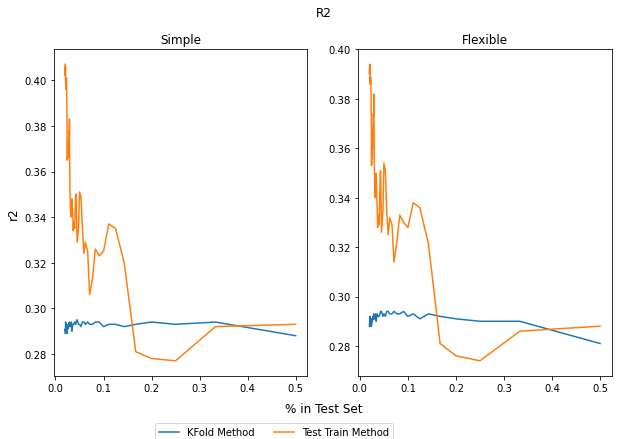

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

axes[0].plot(test_assessment['counter'], test_assessment['r2_simple_cv'], label = "KFold Method")
axes[0].plot(test_assessment['counter'], test_assessment['r2_simple_split'], label = "Test Train Method")
axes[1].plot(test_assessment['counter'], test_assessment['r2_flexible_cv'])
axes[1].plot(test_assessment['counter'], test_assessment['r2_flexible_split'])
fig.suptitle('R2')
axes[0].set_title('Simple')
axes[1].set_title('Flexible')
axes[0].set_ylabel('r2', fontsize=12)
fig.legend(loc = (0.25, -0.005), ncol=2)
fig.text(0.5, 0.04, '% in Test Set', ha='center', fontsize = 12);

In [54]:
r2 = pd.DataFrame()
r2['Model'] = ['Simple + K-Fold', 'Simple + Split', 'Flexible + K-Fold', 'Flexible + Split']
r2['Average'] = [test_assessment['r2_simple_cv'].mean(), 
                  test_assessment['r2_simple_split'].mean(),
                  test_assessment['r2_flexible_cv'].mean(),
                  test_assessment['r2_flexible_split'].mean()]
r2['Max'] = [test_assessment['r2_simple_cv'].max(), 
                  test_assessment['r2_simple_split'].max(),
                  test_assessment['r2_flexible_cv'].max(),
                  test_assessment['r2_flexible_split'].max()]

r2['K-Fold / % in Test'] = [test_assessment.at[test_assessment['r2_simple_cv'].idxmax(), 'kfolds'],
                             test_assessment.at[test_assessment['r2_simple_split'].idxmax(), 'counter'],
                             test_assessment.at[test_assessment['r2_flexible_cv'].idxmax(), 'kfolds'],
                             test_assessment.at[test_assessment['r2_simple_split'].idxmax(), 'counter']]
                             

r2.round(3)

,Model,Average,Max,K-Fold / % in Test
0,Simple + K-Fold,0.293,0.295,22.00
1,Simple + Split,0.347,0.407,0.02
2,Flexible + K-Fold,0.291,0.294,11.00
3,Flexible + Split,0.344,0.394,0.02


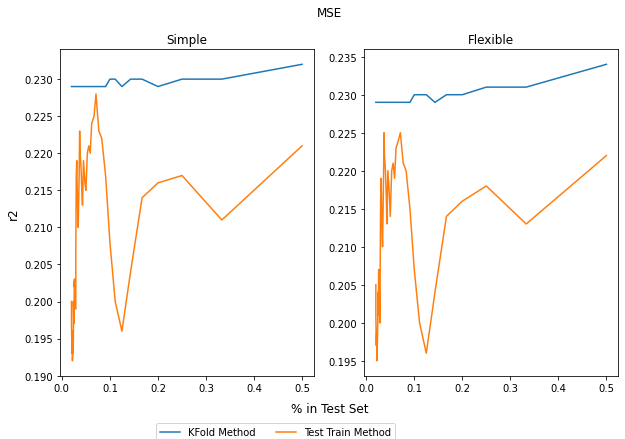

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

axes[0].plot(test_assessment['counter'], test_assessment['mse_simple_cv'], label = "KFold Method")
axes[0].plot(test_assessment['counter'], test_assessment['mse_simple_split'], label = "Test Train Method")
axes[1].plot(test_assessment['counter'], test_assessment['mse_flexible_cv'])
axes[1].plot(test_assessment['counter'], test_assessment['mse_flexible_split'])
fig.suptitle('MSE')
axes[0].set_ylabel('r2', fontsize=12)
axes[0].set_title('Simple')
axes[1].set_title('Flexible')
fig.legend(loc = (0.25, -0.005), ncol=2)
fig.text(0.5, 0.04, '% in Test Set', ha='center', fontsize = 12);


In [ ]:
mse = pd.DataFrame()
mse['Model'] = ['Simple + K-Fold', 'Simple + Split', 'Flexible + K-Fold', 'Flexible + Split']
mse['Average'] = [test_assessment['mse_simple_cv'].mean(), 
                  test_assessment['mse_simple_split'].mean(),
                  test_assessment['mse_flexible_cv'].mean(),
                  test_assessment['mse_flexible_split'].mean()]
mse['Min'] = [test_assessment['mse_simple_cv'].min(), 
                  test_assessment['mse_simple_split'].min(),
                  test_assessment['mse_flexible_cv'].min(),
                  test_assessment['mse_flexible_split'].min()]

mse['K-Fold / % in Test'] = [test_assessment.at[test_assessment['mse_simple_cv'].idxmin(), 'kfolds'],
                             test_assessment.at[test_assessment['mse_simple_split'].idxmin(), 'counter'],
                             test_assessment.at[test_assessment['mse_flexible_cv'].idxmin(), 'kfolds'],
                             test_assessment.at[test_assessment['mse_simple_split'].idxmin(), 'counter']]
                             

mse.round(3)

,Model,Average,Min,K-Fold / % in Test
0,Simple + K-Fold,0.229,0.229,5.000
1,Simple + Split,1.894,1.736,0.027
2,Flexible + K-Fold,0.229,0.229,7.000
3,Flexible + Split,2.081,1.614,0.027


Lastly let's show everything (with adjusted values) in a final table:

In [55]:
p_simp = X_simple.shape[1]
p_flex = X_flexible.shape[1]
n = X_simple.shape[0]

def adj_r2(var, p):
    result = 1 - ((1 -var)*(n)/(n-p))
    return(result)

def adj_mse(var, p):
    result = ((var)*(n))/(n-p)
    return(result)
    



test_assessment['r2_adj_simple'] = np.vectorize(adj_r2)(test_assessment['r2_simple_split'], p_simp)
test_assessment['r2_adj_flexible'] = np.vectorize(adj_r2)(test_assessment['r2_flexible_split'], p_flex)
test_assessment['mse_adj_simple'] = np.vectorize(adj_mse)(test_assessment['mse_simple_split'], p_simp)
test_assessment['mse_adj_flexible'] = np.vectorize(adj_mse)(test_assessment['mse_flexible_split'], p_flex)


final_table = pd.DataFrame()
final_table['Model'] = ['Basic reg', 'Flexible reg']
final_table['R2'] = [test_assessment['r2_simple_split'].max(), 
                     test_assessment['r2_flexible_split'].max()]

final_table['R2 Adjusted'] = [test_assessment['r2_adj_simple'].max(), 
                              test_assessment['r2_adj_flexible'].max()]

final_table['MSE'] = [test_assessment['mse_simple_split'].min(), 
                     test_assessment['mse_flexible_split'].min()]

final_table['MSE Adjusted'] = [test_assessment['mse_adj_simple'].min(), 
                              test_assessment['mse_adj_flexible'].min()]

final_table.round(3)

,Model,R2,R2 Adjusted,MSE,MSE Adjusted
0,Basic reg,0.407,0.401,0.192,0.194
1,Flexible reg,0.394,0.384,0.195,0.198


In sum what we find is that in this context both K-fold & Sample Splitting methods do similar when taking averages, but just the sample split seems to work well.

Overall we see that flexible model fails in this context as it barely increases predictive value but inflates the variable count. This book serves as a simple example of sample splitting however more analysis could be done.